#**Fnet**
---

<font size = 4> 
Fnet is a neural network used to infer the features of cellular structures from brightfield or EM images without coloured labels. The network is trained using paired training images from the same field of view, imaged in a label-free (e.g. brightfield) and labelled condition (e.g. fluorescent protein). When trained, this allows the user to identify certain structures from brightfield images alone. The performance of fnet may depend significantly on the structure at hand.

---
*Disclaimer*:

This notebook is part of the Zero-Cost Deep-Learning to Enhance Microscopy project (https://github.com/HenriquesLab/DeepLearning_Collab/wiki). Jointly developed by the Jacquemet (link to https://cellmig.org/) and Henriques (https://henriqueslab.github.io/) laboratories.

This notebook is largely based on the paper: **Label-free prediction of three-dimensional fluorescence images from transmitted light microscopy** by *Chawin Ounkomol, Sharmishtaa Seshamani, Mary M. Maleckar, Forrest Collman & Gregory R. Johnson*  (https://www.nature.com/articles/s41592-018-0111-2)

And source code found in: https://github.com/AllenCellModeling/pytorch_fnet

**Please also cite this original paper when using or developing this notebook.** 

# **How to use this notebook?**
---

###**Table of contents, Code snippets** and **Files**

On the left side of the notebook you find three tabs which contain from top to bottom the table of contents, code snippets and files

*Table of contents* = contains structure of the notebook. Click the content to move quickly between sections.

*Code snippets* = contain examples how to code certain tasks. You can ignore this when using this notebook.

*Files* = contain all available files. After mounting your google drive (see section 1.) you will find your files and folders here. 

**Remember that all uploaded files are purged after changing the runtime.** All files saved in Google Drive will remain. You do not need to use the Mount Drive-button; your Google Drive is connected in section 1.2.

**Note:** The "sample data" in "Files" contains default files. Do not upload anything here!

---
###**Text** and **Code Cells**

**Text cells** provide information and can be modified by douple-clicking the cell. You are currently reading the text cell. You can create a new text by clicking `+ Text`.

**Code cells** contain code and the code can be modfied by selecting the cell. To execute the cell, move your cursor on the `[ ]`-mark on the left side of the cell (play button appear). Click to execute the cell. After execution is done the animation of play button stops. You can create a new coding cell by clicking `+ Code`.

---
###**Making changes to the notebook**

**Please make a copy** of the notebook and save it to your Google Drive if you make changes. To do this click file -> save a copy in drive.

To **edit a cell**, double click on the text. This will show you either the source code (in code cells) or the source text (in text cells).
It is advisable to use the `#`-mark in code cells. This allows you to keep the original code piece in the cell as a comment.

**For example:**

Original code: all lines are excuted

`my_files = 2`

`my_mask = "names of masks"`

Modified code: the 1st line is not executed, but the 2nd and 3rd line are.

`#my_files = 2`

`my_files = 200`

`my_mask = "names of masks"`

#**0. Before getting started**
---

####This notebook provides two opportunities: firstly, to download and train Fnet with data published in the original manuscript or secondly, to upload a personal dataset and train Fnet on it.
####The notebook may require a large amount of disk space. If using the datasets from the paper, the available disk space on the user's google drive should contain at least 40GB.

##**0.1 Data Format**
<font size = 4> The data used to train fnet must be in either .czi or .tiff (.tif) file format and contain at least one signal and one target channel of each field of view. To use this notebook on user data, upload the data in the following format to your google drive. To ensure corresponding images are used during training give corresponding signal and target images the same name.

**Note: Your *dataset_folder* should not have spaces or brackets in its name as this is not recognized by the fnet code and will throw an error** 

###**For .tif files**
- gdrive
  - My Drive
      - dataset_folder
        - signal
            - img_1, img_2, ...
        - target
            - img_1, img_2, ...

####The folders with your signal and target files should be called 'signal' and 'target', repsectively.

###**For .czi files**
- gdrive
  - My Drive
      - dataset_folder
          - files containing signal and target in separate channels in stack


#**1. Set Runtime type and mount your Google Drive**
---



### **1.1. Import datasets**



Go to **Runtime -> Change the Runtime type**

**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

**Accelator: GPU** *(Graphics processing unit (GPU)*

### **1.2. Mount Google Drive**
<font size = 4> To use this notebook on your own data, you need to mount your Google Drive to this notebook.

<font size = 4> Play the below cell to mount your Google Drive and follow the link. In the new browser window, select your drive and select 'Allow', copy the code, paste into the cell and press enter.

In [1]:
#@markdown ###Mount Google Drive.

#mounts user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#**2. Install Fnet and dependencies**
---
<font size = 4>The fnet folder will be downloaded into your drive and should be found under gdrive/My Drive/pytorch_fnet. As Fnet needs a several packages to be installed, this step may take a few minutes. 

In [2]:
#@markdown ###Play this cell to download fnet to your drive. If it is already installed this will only install the fnet dependencies.

#clone fnet from github to colab
import shutil
import os
!pip install -U scipy==1.2.0
if not os.path.exists('/content/gdrive/My Drive/pytorch_fnet'):
  !git clone -b release_1 --single-branch https://github.com/AllenCellModeling/pytorch_fnet.git; cd pytorch_fnet; pip install .
  shutil.move('/content/pytorch_fnet','/content/gdrive/My Drive/pytorch_fnet')

     |████████████████████████████████| 26.6MB 113kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


#**3. Select your paths and parameters**
---
<font size = 5> **Datasets**

<font size = 4> Fnet comes with a repository of training datasets. 

<font size = 4> **`Choose Dataset:`** gives you the choice to use these datasets or your own dataset to train fnet. Choosing *Use Own Data* has the advantage that inference on further data of the same type will likely be better than training on other datasets. However, if such a dataset is unavailable or you want to test on the fnet datasets, choose the *Download Data* option.

<font size = 4> **If** you choose ***Download Dataset*** select which one you want to use from the dropdown **`download_dataset`**.

<font size = 5> **Paths for training data**

<font size = 4> **If** you ***Use Own Dataset*** enter the path of the folder your source and target folders are located in in the **`own_dataset`** field. The name of this folder will decide the name of the model you train.

<font size = 4> **`signal_folder:`** Enter the path of the folder with the signal data (should be inside own_dataset).

<font size = 4> **`target_folder:`** Enter the path of the folder with the target data (should be inside own_dataset).

<font size = 5> **Training Parameters**

<font size = 4> **`epochs:`** Input how many epochs (rounds) the network will be trained. A larger number of epochs may improve performance but risks overfitting to the training data. The authors suggest at least **50000 epochs** on their own datasets, although less can be used to test the network's working. Training for this amount will require **several hours**, usually.

<font size = 4>**`number_of_images:`** The **number of images** corresponds to the amount of images from your total dataset you will use to train Fnet. Note that 25% of the images is set aside for testing, so if the number of images chosen is greater than 75% of your dataset you may encounter an error.

<font size =4>**`batch_size:`** Reducing or increasing the **batch size** may slow or speed up your training, respectively, and can influence network performance.

####**Troubleshooting:**

<font size = 4> Not enough disk space to download fnet data: If colab disconnects during the download, the disk space provided by colab may run out. Usually, this is prevented as data gets moved to the user's google drive. If the problem persists even after restarting the run time, the dataset may need to be downloaded externally and then manually moved to google drive (use the code below, but on your own machine).

In [0]:
#@markdown ###Datasets
#@markdown Will you be using your *own data* **or** *data from the fnet repository*?
import os
import csv
import shutil


#Datasets

choose_dataset_options = "Use Own Dataset" #@param ["Download Dataset", "Use Own Dataset"]

#@markdown **If** you chose **Download Dataset**, select the dataset to download and train on.
download_dataset = "fibrillarin" #@param ["choose dataset", "beta_actin", "myosin_iib", "membrane_caax_63x", "desmoplakin", "sec61_beta", "st6gal1", "fibrillarin", "lamin_b1", "dic_lamin_b1", "alpha_tubulin", "tom20", "zo1", "timelapse_wt2_s2"]

#@markdown ---

#@markdown ###Select Paths

#@markdown **If** you chose **Own Dataset**, enter the path of the folder the dataset is contained in (own dataset). You also need to enter the paths to the signal and target folders.

#Paths

#Fetch the path and extract the name of the training dataset
own_dataset = "/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Training datasets/Artificial_labelling_fnet" #@param {type:"string"}
dataset_name = os.path.basename(os.path.normpath(own_dataset))

#Fetch the path and extract the name of the signal folder
signal_folder = "/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Training datasets/Artificial_labelling_fnet/Training - Bright-field" #@param {type: "string"}
signal_name = os.path.basename(os.path.normpath(signal_folder))

#Fetch the path and extract the name of the signal folder
target_folder = "/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Training datasets/Artificial_labelling_fnet/Training - Fluorescence (nuclear marker)" #@param {type: "string"}
target_name =  os.path.basename(os.path.normpath(target_folder))

if choose_dataset_options == "Download Dataset":
  dataset = download_dataset
  dataset_x = dataset+"}"
  #check if the dataset already exists in the data folder. If not, then download.
  if not os.path.exists('/content/gdrive/My Drive/pytorch_fnet/data/'+dataset):
    os.chdir('/content/gdrive/My Drive/pytorch_fnet')
    !chmod u+x ./scripts/paper/download_all_data.sh #add permissions to edit sh file
    !sed -i 's/(.*)/("$dataset")/' ./scripts/paper/download_all_data.sh #change dataset to be downloaded in the download_all_data.sh file
    !./scripts/paper/download_all_data.sh #download dataset
else:
  dataset = dataset_name

  #Here, we check if the dataset already exists. If not, copy the dataset from google drive to the data folder
  
  if not os.path.exists('/content/gdrive/My Drive/pytorch_fnet/data/'+dataset):
    shutil.copytree(own_dataset,'/content/gdrive/My Drive/pytorch_fnet/data/'+dataset)
  else:
    print('The dataset is already in the right location')
  
  #Create a path_csv file to point to the training images
  os.chdir('/content/gdrive/My Drive/pytorch_fnet/data')
  signal = os.listdir('./'+dataset+'/'+signal_name)
  target = os.listdir('./'+dataset+'/'+target_name)
  with open(dataset+'.csv', 'w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(["path_signal","path_target"])
      for i in range(0,len(signal)):
        writer.writerow(["/content/gdrive/My Drive/pytorch_fnet/data/"+dataset+"/"+signal_folder+"/"+signal[i],"/content/gdrive/My Drive/pytorch_fnet/data/"+dataset+"/"+target_folder+"/"+target[i]])

  shutil.move('/content/gdrive/My Drive/pytorch_fnet/data/'+dataset+'.csv','/content/gdrive/My Drive/pytorch_fnet/data/csvs/'+dataset+'.csv')

print("Selected "+dataset+" as training set")

dataset_x = dataset+"}" # this variable is only used to ensure closed curly brackets when editing the .sh files

#@markdown ---

#@markdown ###Training Parameters

#Training parameters in fnet are indicated in the train_model.sh file.
#Here, we edit this file to include the desired parameters

#1. Add permissions to train_model.sh
os.chdir("/content/gdrive/My Drive/pytorch_fnet/scripts")
!chmod u+x train_model.sh

#2. Select parameters
epochs =  10000#@param {type:"number"}
number_of_images =  14#@param {type:"number"}
batch_size =  4#@param {type:"number"}

#3. Insert the above values into train_model.sh
!if ! grep saved_models\/\${ train_model.sh;then sed -i 's/saved_models\/.*/saved_models\/\${DATASET}"/g' train_model.sh; fi 
!sed -i "s/1:-.*/1:-$dataset_x/g" train_model.sh #change the dataset to be trained with
!sed -i "s/N_ITER=.*/N_ITER=$epochs/g" train_model.sh #change the number of training iterations (epochs)
!sed -i "s/BUFFER_SIZE=.*/BUFFER_SIZE=$number_of_images/g" train_model.sh #change the number of training images
!sed -i "s/BATCH_SIZE=.*/BATCH_SIZE=$batch_size/g" train_model.sh #change the batch size

#4. class_dataset
#Fnet uses specific dataset classes depending on the type of input data the user uses.
#Here, we use the path_csv file to find out if the dataset needs to be a tiff or czi dataset.

mycsv = csv.reader(open('/content/gdrive/My Drive/pytorch_fnet/data/csvs/'+dataset+'.csv'))
for row in mycsv:
   text = row[0]
os.chdir("/content/gdrive/My Drive/pytorch_fnet/")

#If the dataset has czi files, and the train_model.sh has either no class_dataset argument 
#or class_dataset = TiffDataset we change it to CziDataset
if text.endswith('.czi'):
  !if ! grep class_dataset ./scripts/train_model.sh;then sed -i 's/ITER} \\/ITER} \\\'$''\n'       --class_dataset CziDataset \\/' ./scripts/train_model.sh; fi
  !if grep TiffDataset ./scripts/train_model.sh;then sed -i 's/TiffDataset/CziDataset/' ./scripts/train_model.sh; fi

#If the dataset has tif or tiff files, and the train_model.sh has either no class_dataset argument 
#or class_dataset = CziDataset we change it to TiffDataset
elif text.endswith('.tif') or text.endswith('.tiff'):
  !chmod u+x ./scripts/train_model.sh
  !if ! grep class_dataset ./scripts/train_model.sh;then sed -i 's/ITER} \\/ITER} \\\'$''\n'       --class_dataset TiffDataset \\/' ./scripts/train_model.sh; fi
  !if grep CziDataset ./scripts/train_model.sh;then sed -i 's/CziDataset/TiffDataset/' ./scripts/train_model.sh; fi

The dataset is already in the right location
Selected Artificial_labelling_fnet as training set
RUN_DIR="saved_models/${DATASET}"
       --class_dataset TiffDataset \


#**4. Train the model**
---
<font size = 4>Before training, carefully read the different options. This applies especially if you have trained fnet on a dataset before. When training is complete your model will be saved in the *saved_models* folder inside pytorch_fnet under the name of your training dataset folder.

<font size = 4>If you are training on your own data, check that your path_csv is uploaded to the pytorch_fnet/data/csvs folder before playing the below cell

###**Choose one of the options to train fnet**.

<font size = 4>**4.1.** If this is the first training on the chosen dataset, play this section to start training.

<font size = 4>**4.2.** If you want to train your model from scratch again on the same dataset play this section.

<font size = 4>**4.3.** If you want to continue training on an already trained model choose this section

##**4.1. Train a new model**

####Play the cell below if you have not trained on this dataset before.

In [0]:
#@markdown ###4.1. Start Training
#with 50 images in buffer from dataset and 5000 epochs, takes around 1:30h

#This tifffile release runs error-free in this version of fnet.
!pip install tifffile==2019.7.26

os.chdir('/content/gdrive/My Drive/pytorch_fnet/')

#Here we import an additional module to the functions.py file to run it without errors.
#This may be a small bug in the original code.

f = open("functions.py", "r")
contents = f.readlines()
f.close()
f = open("functions.py", "r")
if not 'import fnet.fnet_model' in f.read():
  contents.insert(5, 'import fnet.fnet_model')
f.close()
f = open("functions.py", "w")
contents = "".join(contents)
f.write(contents)
f.close()

#Here we start the training
!./scripts/train_model.sh $dataset 0

+ DATASET=Artificial_labelling_fnet
+ N_ITER=1000
+ BUFFER_SIZE=14
+ BATCH_SIZE=4
+ RUN_DIR=saved_models/Artificial_labelling_fnet
+ PATH_DATASET_ALL_CSV=data/csvs/Artificial_labelling_fnet.csv
+ PATH_DATASET_TRAIN_CSV=data/csvs/Artificial_labelling_fnet/train.csv
+ GPU_IDS=0
+++ dirname ./scripts/train_model.sh
++ cd ./scripts
++ pwd
+ cd /content/gdrive/My Drive/pytorch_fnet/scripts/..
./scripts/train_model.sh: line 12: cd: too many arguments
+ python scripts/python/split_dataset.py data/csvs/Artificial_labelling_fnet.csv data/csvs --train_size 0.75 -v
Using existing train/test split.
+ python train_model.py --n_iter 1000 --class_dataset TiffDataset --path_dataset_csv data/csvs/Artificial_labelling_fnet/train.csv --buffer_size 14 --buffer_switch_frequency 2000000 --batch_size 4 --path_run_dir saved_models/Artificial_labelling_fnet --gpu_ids 0
model loaded from: saved_models/Artificial_labelling_fnet/model.p
fnet_nn_3d | {} | iter: 1000
History loaded from: saved_models/Artificial_lab

##**4.2. Train a model from scratch again**

####If you have trained a model previously on the same dataset and want to train from scratch again, play the cell below. Check the box if you want to save the previously trained model (to user's google drive). If unchecked, this will delete the previously trained model.

In [0]:
!pip install tifffile==2019.7.26
import shutil
import os
Save_previous_models = False #@param {type:"boolean"}
if Save_previous_models == True:
  shutil.move('/content/gdrive/My Drive/pytorch_fnet/saved_models/'+dataset,'/content/gdrive/My Drive/saved_models/'+dataset)
else:
  shutil.rmtree('/content/gdrive/My Drive/pytorch_fnet/saved_models/'+dataset)

     |████████████████████████████████| 133kB 3.4MB/s 


In [0]:
#@markdown ###4.2. Start Training
os.chdir('/content/gdrive/My Drive/pytorch_fnet/')
#!chmod u+x ./scripts/train_model.sh
#!sed -i "s/1:-.*/1:-$dataset_x/g" train_model.sh
!./scripts/train_model.sh $dataset 0

##**4.3. Training from a previously saved model**
<font size = 4>This section allows you to use networks you have previously trained and saved in your pytorch_fnet folder and to continue training them for more epochs or on a different dataset.

In [0]:
#@markdown To test if performance improves after the initial training, you can continue training on the old model. This option can also be useful if Colab disconnects or times out.
#@markdown Type the name (not the path) of the dataset you want to continue training on.
import csv

dataset = "Artificial_labelling_fnet" #@param {type:"string"}
dataset_x = dataset+"}"
os.chdir('/content/gdrive/My Drive/pytorch_fnet/scripts')
#Change the train_model.sh file to include chosen dataset
!sed -i "s/1:-.*/1:-$dataset_x/g" train_model.sh

#@markdown If the above dataset is different to the one the network was originally trained on tick the box and enter the name of that (original) dataset below.
#@markdown If not, then untick the box and continue below.
train_with_different_data = False #@param {type:"boolean"}

original_dataset = "nucleus" #@param {type:"string"}

#Find the number of previous training epochs from loss csv file
#with open('/content/drive/My Drive/pytorch_fnet/saved_models/'+dataset+'/losses.csv') as f:
if train_with_different_data==False:
  with open('/content/gdrive/My Drive/pytorch_fnet/saved_models/'+dataset+'/losses.csv') as f:
    previous_epochs = sum(1 for line in f)
  print('continuing training after epoch '+str(previous_epochs-1))
else:
  with open('/content/gdrive/My Drive/pytorch_fnet/saved_models/'+original_dataset+'/losses.csv') as f:
    previous_epochs = sum(1 for line in f)
  print('continuing training after epoch '+str(previous_epochs-1))

print('To start re-training play section 5.3. below')


#@markdown For how many additional epochs do you want to train the model?
#@markdown Before choosing a value check the number of previous epochs in the losses.csv file found in your dataset folder in saved_models. The number of rows in the losses.csv corresponds to the number of previous epochs.
add_epochs =  5500#@param {type:"number"}

#Calculate the new number of total training epochs. Subtract 1 to discount the title row of the csv file.
new_epochs = previous_epochs + add_epochs -1
os.chdir('/content/gdrive/My Drive/pytorch_fnet/scripts')

#Edit train_model.sh file to include new total number of training epochs
!sed -i "s/N_ITER=.*/N_ITER=$new_epochs/g" train_model.sh


if train_with_different_data == True:
  !sed -i "s/models\/.*/models\/$original_dataset\"/g" train_model.sh

continuing training after epoch 69500
To start re-training play section 5.3. below


In [0]:
#@markdown ###4.3. Start re-training model
!pip install tifffile==2019.7.26
import os
os.chdir('/content/gdrive/My Drive/pytorch_fnet/fnet')

#Here we import an additional module to the functions.py file to run it without errors.
f = open("functions.py", "r")
contents = f.readlines()
f.close()
f = open("functions.py", "r")
if not 'import fnet.fnet_model' in f.read():
  contents.insert(5, 'import fnet.fnet_model')
f.close()
f = open("functions.py", "w")
contents = "".join(contents)
f.write(contents)
f.close()

#Here we retrain the model on the chosen dataset.
os.chdir('/content/gdrive/My Drive/pytorch_fnet/')
!chmod u+x ./scripts/train_model.sh
!./scripts/train_model.sh $dataset 0

Streaming output truncated to the last 5000 lines.
num_iter:  70042 | loss_batch: 0.259
num_iter:  70043 | loss_batch: 0.209
num_iter:  70044 | loss_batch: 0.223
num_iter:  70045 | loss_batch: 0.402
num_iter:  70046 | loss_batch: 0.134
num_iter:  70047 | loss_batch: 0.283
num_iter:  70048 | loss_batch: 0.554
num_iter:  70049 | loss_batch: 0.317
num_iter:  70050 | loss_batch: 0.196
num_iter:  70051 | loss_batch: 0.262
num_iter:  70052 | loss_batch: 0.629
num_iter:  70053 | loss_batch: 0.361
num_iter:  70054 | loss_batch: 0.338
num_iter:  70055 | loss_batch: 0.258
num_iter:  70056 | loss_batch: 0.525
num_iter:  70057 | loss_batch: 0.204
num_iter:  70058 | loss_batch: 0.224
num_iter:  70059 | loss_batch: 0.117
num_iter:  70060 | loss_batch: 0.128
num_iter:  70061 | loss_batch: 0.203
num_iter:  70062 | loss_batch: 0.093
num_iter:  70063 | loss_batch: 0.388
num_iter:  70064 | loss_batch: 0.138
num_iter:  70065 | loss_batch: 0.126
num_iter:  70066 | loss_batch: 0.419
num_iter:  70067 | loss_

#**5. Use the network**
---

### **5.1. Generate prediction from test dataset**
<font size = 4>Fnet will store your results in a list beginning with 00, 01, 02 etc.
Inside each of these there will be a test, predicted, and target file. You can ignore the target file as in this case there usually will be no target. Your test source and the resulting prediction are the images labelled test.tiff and predicted*Predictions_folder*.tiff.

In [0]:
#Before prediction we will remove the old prediction folder because fnet won't execute if a path already exists that has the same name.
#This is just in case you have already trained on a dataset with the same name
#The data will be saved outside of the pytorch_folder (Results_folder) so it won't be lost when you run this section again.

import shutil
if os.path.exists('/content/gdrive/My Drive/pytorch_fnet/results'):
  shutil.rmtree('/content/gdrive/My Drive/pytorch_fnet/results')


!pip install -U scipy==1.2.0
!pip install --no-cache-dir tifffile==2019.7.26 
from distutils.dir_util import copy_tree

Test_data_folder = "/content/gdrive/My Drive/Zero-Cost Deep-Learning to Enhance Microscopy/Notebooks to be tested/Training datasets/Artificial_labelling_fnet/Test - Bright-field" #@param {type:"string"}
Results_folder = "/content/gdrive/My Drive" #@param {type:"string"}

#@markdown ###Under what name do you want to store your output files (no spaces)?
Predictions_folder = "NewTest" #@param {type:"string"}
Predictions_folder_x = Predictions_folder+"}"

#@markdown ###Do you want to use the current trained model?

use_the_current_trained_model = True #@param{type:"boolean"}

#@markdown ###If not, provide the name of the model you want to use 
#@markdown (previously saved models are found in the pytorch_fnet/saved_models folder)

inference_model_name = "" #@param {type:"string"}
if use_the_current_trained_model == True:
  #Move the contents of the saved_models folder from your training to the new folder
  #Here, we use a different copyfunction as we only need the contents of the trained_model folder
  copy_tree('/content/gdrive/My Drive/pytorch_fnet/saved_models/'+dataset,'/content/gdrive/My Drive/pytorch_fnet/saved_models/'+Predictions_folder)
else:
  copy_tree('/content/gdrive/My Drive/pytorch_fnet/saved_models/'+inference_model_name,'/content/gdrive/My Drive/pytorch_fnet/saved_models/'+Predictions_folder)

# Get the name of the folder the test data is in
test_dataset_name = os.path.basename(os.path.normpath(Test_data_folder))

# Get permission to the predict.sh file and change the name of the dataset to the Predictions_folder.
os.chdir('/content/gdrive/My Drive/pytorch_fnet/')
!chmod u+x /content/gdrive/My\ Drive/pytorch_fnet/scripts/predict.sh
!sed -i "s/1:-.*/1:-$Predictions_folder_x/g" /content/gdrive/My\ Drive/pytorch_fnet/scripts/predict.sh

#Are you using .tif or .czi files?
os.chdir('/content/gdrive/My Drive/pytorch_fnet')
mycsv = csv.reader(open('/content/gdrive/My Drive/pytorch_fnet/data/csvs/'+dataset+'.csv'))
for row in mycsv:
   text = row[1]

#We need to ensure that the correct dataset class for the dataset is chosen.
#For both CziDataset and TiffDataset Classes we need to test first if the Dataset Class object already exists (grep) in the predict file, and if not insert the correct one.
#If the Dataset Object exists but is not the correct one for the respective dataset (e.g. CziDataset instead of TiffDataset) we need to change it.
if text.endswith('.czi'):
  !if ! grep class_dataset /content/gdrive/My\ Drive/pytorch_fnet/scripts/predict.sh;then sed -i 's/DIR} \\/DIR} \\\'$''\n'     --class_dataset CziDataset \\/' /content/gdrive/My\ Drive/pytorch_fnet/scripts/predict.sh; fi
  !if grep TiffDataset /content/gdrive/My\ Drive/pytorch_fnet/scripts/predict.sh;then sed -i 's/TiffDataset/CziDataset/' ./scripts/predict.sh; fi
elif text.endswith('.tif') or text.endswith('.tiff'):
  !chmod u+x /content/gdrive/My\ Drive/pytorch_fnet//scripts/predict.sh
  !if ! grep class_dataset /content/gdrive/My\ Drive/pytorch_fnet/scripts/predict.sh;then sed -i 's/DIR} \\/DIR} \\\'$''\n'     --class_dataset TiffDataset \\/' /content/gdrive/My\ Drive/pytorch_fnet/scripts/predict.sh; fi
  !if grep CziDataset /content/gdrive/My\ Drive/pytorch_fnet/scripts/predict.sh;then sed -i 's/CziDataset/TiffDataset/' /content/gdrive/My\ Drive/pytorch_fnet/scripts/predict.sh; fi   


#Create test_data folder in pytorch_fnet

# If your test data is not in the pytorch_fnet data folder it needs to be copied there.

if not os.path.exists('/content/gdrive/My Drive/pytorch_fnet/data/'+dataset+'/'+test_dataset_name):
    shutil.copytree(test_dataset,'/content/gdrive/My Drive/pytorch_fnet/data/'+dataset+'/'+test_dataset_name)

# Make a folder that will hold the test.csv file in your new folder
os.chdir('/content/gdrive/My Drive/pytorch_fnet/data/csvs')
if not os.path.exists('/content/gdrive/My Drive/pytorch_fnet/data/csvs/'+Predictions_folder):
  os.mkdir('/content/gdrive/My Drive/pytorch_fnet/data/csvs/'+Predictions_folder)


os.chdir('/content/gdrive/My Drive/pytorch_fnet/data/csvs/')


#Make a new folder in saved_models to use the trained model for inference.
if not os.path.exists('/content/gdrive/My Drive/pytorch_fnet/saved_models/'+Predictions_folder):
  os.mkdir('/content/gdrive/My Drive/pytorch_fnet/saved_models/'+Predictions_folder) 


#Get file list from the folders containing the files you want to use for inference and as GT reference.
test_signal = os.listdir('/content/gdrive/My Drive/pytorch_fnet/data/'+dataset+'/'+test_dataset_name)

#Now we make a path csv file to point the predict.sh file to the correct paths for the inference files.
os.chdir('/content/gdrive/My Drive/pytorch_fnet/data/csvs/'+Predictions_folder+'/')

#If an old test csv exists we want to overwrite it, so we can insert new test data.
if os.path.exists('/content/gdrive/My Drive/pytorch_fnet/data/csvs/'+Predictions_folder+'/test.csv'):
  os.remove('/content/gdrive/My Drive/pytorch_fnet/data/csvs/'+Predictions_folder+'/test.csv')

#Here we create a new test.csv
with open('test.csv', 'w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(["path_signal","path_target"])
      for i in range(0,len(test_signal)):
        writer.writerow(["/content/gdrive/My Drive/pytorch_fnet/data/"+dataset+"/"+test_dataset_name+"/"+test_signal[i],"/content/gdrive/My Drive/pytorch_fnet/data/"+dataset+"/"+test_dataset_name+"/"+test_signal[i]])
        
#We run the predictions
os.chdir('/content/gdrive/My Drive/pytorch_fnet/')
!/content/gdrive/My\ Drive/pytorch_fnet/scripts/predict.sh $Predictions_folder 0

#Save the results
shutil.copytree('/content/gdrive/My Drive/pytorch_fnet/results/3d/'+Predictions_folder+'/test',Results_folder+"/"+Predictions_folder)

     |████████████████████████████████| 26.6MB 49.0MB/s 
ERROR: tensor2tensor 1.14.1 requires bz2file, which is not installed.
ERROR: tensor2tensor 1.14.1 requires gevent, which is not installed.
ERROR: tensor2tensor 1.14.1 requires gunicorn, which is not installed.
ERROR: tensor2tensor 1.14.1 requires kfac, which is not installed.
ERROR: tensor2tensor 1.14.1 requires mesh-tensorflow, which is not installed.
ERROR: tensor2tensor 1.14.1 requires pypng, which is not installed.
ERROR: tensor2tensor 1.14.1 requires tensorflow-datasets, which is not installed.
ERROR: tensor2tensor 1.14.1 requires tensorflow-gan, which is not installed.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
     |████████████████████████████████| 133kB 19.7MB/s 
     --class_dataset TiffDataset \
+ DATASET=NewTest
+ MODEL_DIR=saved

'/content//NewTest'

##**5.2. Assess predicted output**

     |████████████████████████████████| 12.6MB 248kB/s 
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.3 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


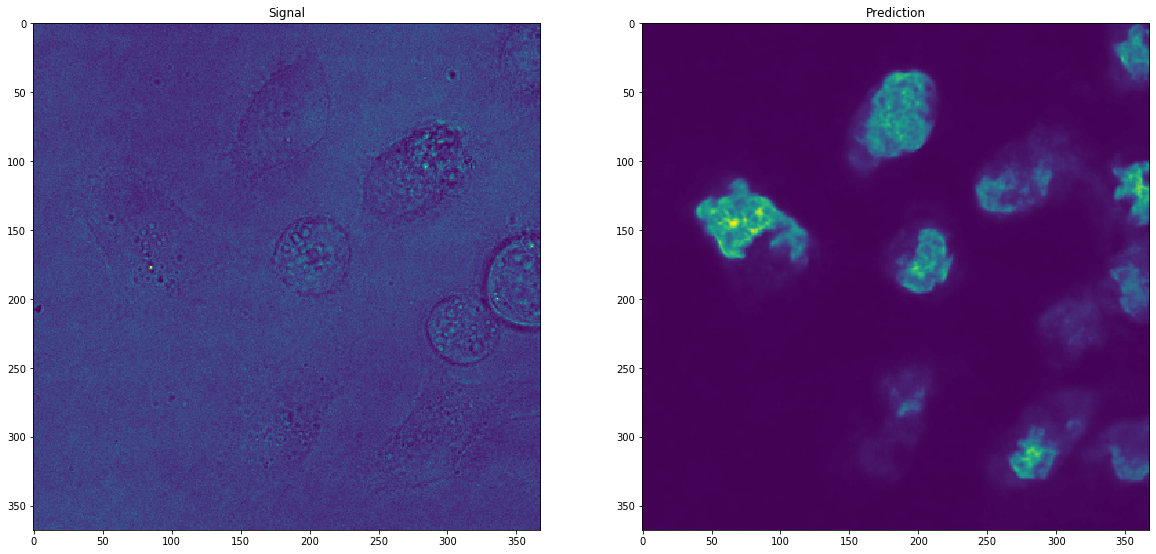

In [0]:
!pip install matplotlib==2.2.3
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os

#@markdown ###Select the image you would you like to view?
image = "00" #@param {type:"string"}
os.chdir(Results_folder+"/"+Predictions_folder+"/"+image)

#@markdown ###Select the slice would you like to view?
slice_number = 21 #@param {type:"number"}
I = io.imread('signal.tiff')
I = np.squeeze(I,axis=(0,))
J = io.imread('prediction_'+Predictions_folder+'.tiff')
J = np.squeeze(J,axis=(0,))

#Create the figure
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(20)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.title.set_text('Signal')
ax2.title.set_text('Prediction')

ax1.imshow(I[slice_number,:,:])
ax2.imshow(J[slice_number,:,:])

### **5.3. Download your predicted output**

<font size = 4>**Store your data** and ALL its results elsewhere by downloading it from Google Drive and after that clean the original folder tree (datasets, results, trained model etc.) if you plan to train or use new networks. Please note that notebook will otherwise **OVERWRITE** all files which have the same name.